This notebook illustrates methods to fill missing data for a time series using a variety of methods.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
sns.set_context('talk')

# Load dataset

The dataset can be obtained from this [link](https://raw.githubusercontent.com/facebook/prophet/master/examples/example_air_passengers.csv).
Save it in the Datasets directory with the filename `example_air_passengers.csv`.

In [2]:
df = pd.read_csv('../Datasets/example_air_passengers.csv', parse_dates=['ds'], index_col=['ds'], nrows=160)
df.iloc[10:11] = np.NaN
df.iloc[25:28] = np.NaN
df.iloc[40:45] = np.NaN
df.iloc[70:94] = np.NaN

In [3]:
df.head()

,y
ds,
1992-01-01,146376.0
1992-02-01,147079.0
1992-03-01,159336.0
1992-04-01,163669.0
1992-05-01,170068.0


# Check for missing data

We check for missing data in the target and quantify how many missing values there are.

In [4]:
n_missing = df['y'].isnull().sum()

print(f"Number of datapoints missing: {n_missing}")
print(f"Proportion of dataset missing: {n_missing/len(df):.2%}")

Number of datapoints missing: 33
Proportion of dataset missing: 20.62%


We plot the time series to see where the data is missing.

<AxesSubplot:xlabel='ds'>

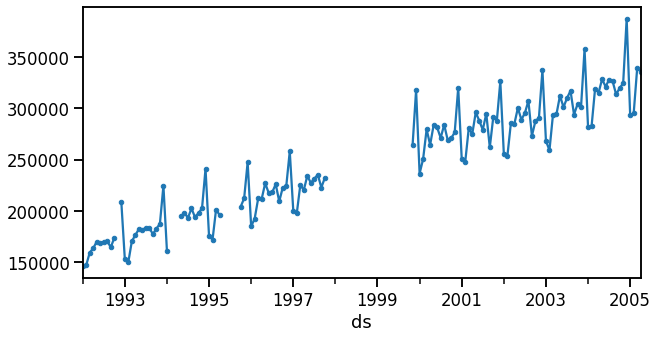

In [5]:
df.plot(marker='.', figsize=[10, 5], legend=None)


# Method 1: Forwardfill and Backfill

Apply the forward fill method. This method is also known as "last observation carried forward".

<AxesSubplot:xlabel='ds'>

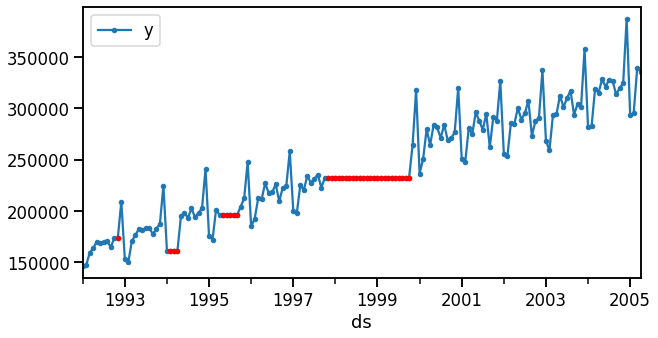

In [6]:
# Apply the forward fill method
df_imputed = df.fillna(method='ffill')

# Plot the imputed time series
ax = df_imputed.plot(linestyle='-', marker='.', figsize=[10, 5])
df_imputed[df.isnull()].plot(ax=ax, legend=None, marker='.', color='r')

We now compare this with the backfill method. This method is also known as "next observation carried backwards".

In [7]:
# Apply the backfill method
df_imputed = df.fillna(method='bfill')


<AxesSubplot:xlabel='ds'>

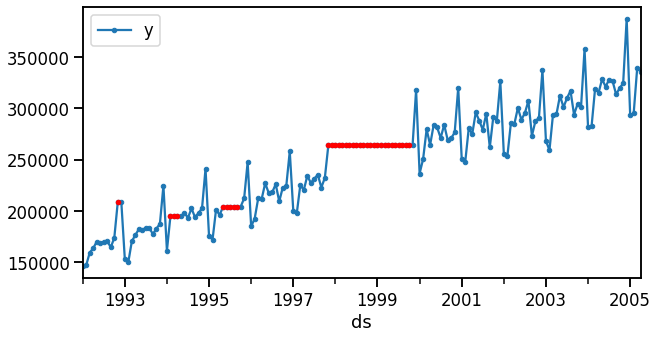

In [8]:
# Apply the backfill method
df_imputed = df.fillna(method='bfill')

# Plot the imputed time series
ax = df_imputed.plot(linestyle='-', marker='.', figsize=[10, 5])
df_imputed[df.isnull()].plot(ax=ax, legend=None, marker='.', color='r')

The above figures show that these methods can distort important structures of the time series (e.g., the shape of a seasonal component) depending on how large the gaps of missing data are. If these gaps are small then the distortions are small, if the gaps are large then the distortions are also large. A gap is small or large relative to structures found in the time series (i.e., the lengths of the seasonal period or steepness of a trend line).

The distortions to the time series created by data imputation can negatively impact the fitting of a model. If the proportion of missing data is small then the impact of these distortions on the fitting of a model should be less and may be tolerable depending on the use case.

One minor advantage of forwad filling over backward filling and the interpolation methods below is that it does not leak any data from the future to the imputed data points.  The impact of this depends on how much data has been imputed and may not make a noticable difference if the size of the missing value gaps is small relative to structure in the time series. 

If a dataset has missing data with small gap sizes then forwardfilling would be a sufficient method to impute missing data without distorting the time series too heavily and ensuring no data leakage is occuring.

# Method 2: Linear interpolation

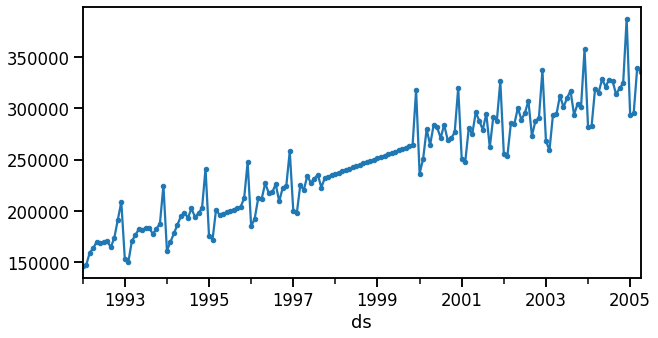

In [9]:
# Apply the linear interpolation method
# Note: If the time interval between rows are not uniform then
# the method should set as 'time' to achieve a linear fit. 
df_imputed = df.interpolate(method='linear')

# Plot the imputed time series
ax = df_imputed.plot(linestyle='-', marker='.', figsize=[10, 5], legend=None)
#df_imputed[df.isnull()].plot(ax=ax, legend=None, marker='.', color='r')

We can see here that linear interpolation is reasonable for small gaps but also captures the trend for larger gaps, however, the seasonality is lost.

# Method 3: Spline interpolation

Typically the order parameter is relatively low when using splines, 3 is common. This is because higher order splines will begin fitting more complex or larger magntidue curves between missing values.

Note: Splines are generally preferred to polynomial interpolation. This is because splines are less senstive than a polynomial fit to small changes to the data points that they are fitting.

<AxesSubplot:xlabel='ds'>

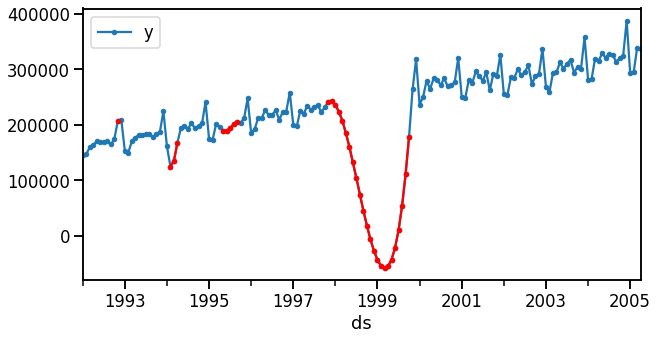

In [10]:
# Apply the spline interpolation method
df_imputed = df.interpolate(method='spline', order=3)

# Plot the imputed time series
ax = df_imputed.plot(linestyle='-', marker='.', figsize=[10, 5])
df_imputed[df.isnull()].plot(ax=ax, legend=None, marker='.', color='r')

We can see that cubic splines are not appropriate when there are large gaps in the data.

# Method 4: Seasonal decomposition and interpolation

These methods involve estimating the seasonal component of a time series. This is then subtracted from the original time series to provide a de-seasoned time series. Any of the prior interpolation methods can then be used on the de-seasoned time series and the seasonal component can be added back to the de-seasoned time series. 

There are many different methods to decompose a time series into seasonal and other components. We show two below.

## 4.1: Seasonal-Trend decomposition using LOESS (STL)


In this section we show how to use the STL method to extract the seasonal component of a time series. An advantage of STL is that it is able to estimate a seasonal component which can change over time (e.g., if the amplitude or frequency of the seasonal component changes).

The details of the method can be found in the original paper here: http://www.nniiem.ru/file/news/2016/stl-statistical-model.pdf

In [11]:
from statsmodels.tsa.seasonal import STL

STL can't handle missing data. A linear interpolation is typically used to fill missing data before decompsing the time series using STL. 

In [12]:
# Apply STL decomposition 
res = STL(df, seasonal=7).fit()
seasonal_component = res.seasonal 

In [13]:
res = STL(df.interpolate(method='linear'), seasonal=29).fit()

The seasonal parameter determines how much data is used to infer the seasonality at any given point. If the seasonal component is thought to be fixed throughout time then a large seasonal parameter can be set so that more data is used to determine the seasonal component. Likewise if the seasonal component is thought to change (e.g., the frequency) quickly over time the seasonal parameter can be reduced so that only recent data contributes to determining the seasonal component. 

The large missing gap is linearly interpolated. This means that the algorithm sees a region of data with no seasonal component and could distort the estimation of the seasonal component. A large seasonal parameter is set to overcome this. This works because a larger portion of the data is now used to estimate the seasonal component meaning that the local distortion from the interpolation has less effect.

We now plot the decomposition to inspect that it is reasonable.

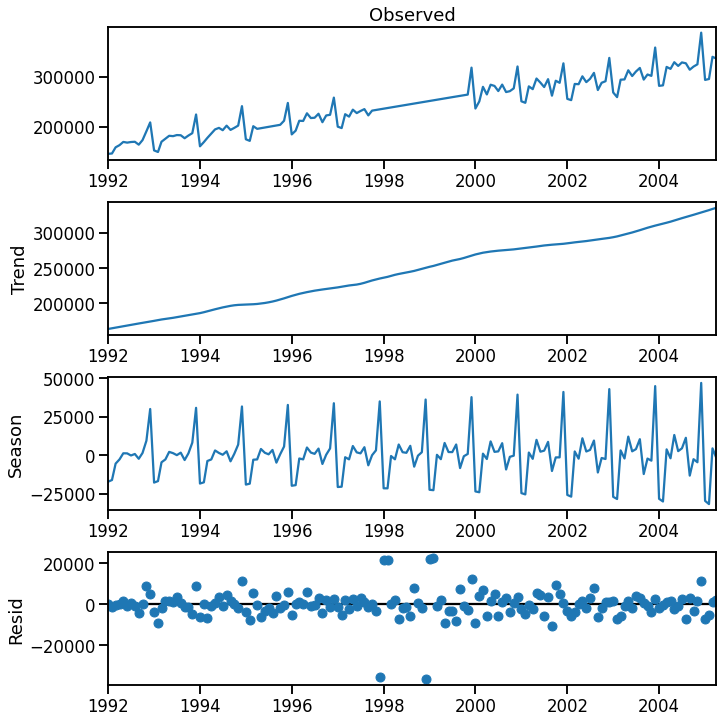

In [14]:
plt.rc('figure',figsize=(10,10))
plt.rc('font',size=5)
res.plot();

We now:
1) extract the seasonal component
2) de-seasonalise the original time series
3) perform linear interpolation on the de-seasonalised data
4) Add the seasonal component back to the imputed de-seasonalised data

In [15]:
# Extract seasonal component
seasonal_component = res.seasonal
seasonal_component.head()

ds
1992-01-01   -17292.988754
1992-02-01   -16182.630226
1992-03-01    -5511.368012
1992-04-01    -2751.422867
1992-05-01     1218.554174
Name: season, dtype: float64

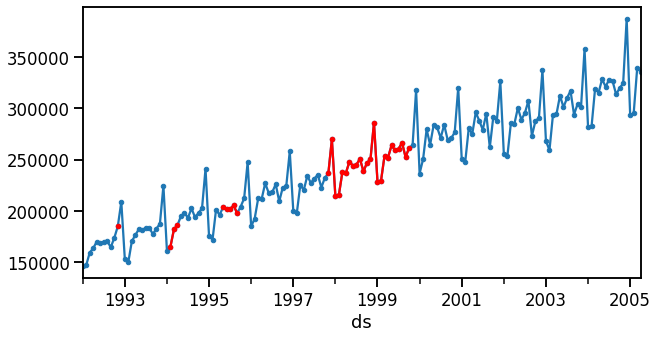

In [16]:
# De-seasonlise original data
df_deseasonalised = df['y'] - seasonal_component

# Perform linear interpolation on de-seasonalised data
df_deseasonalised_imputed = df_deseasonalised.interpolate(method='linear')

# Add seasonal component back to get the final imputed time series
df_imputed = df_deseasonalised_imputed + seasonal_component

# Plot the imputed time series
df_imputed = df_imputed.to_frame().rename(columns={0:'y'})
ax = df_imputed.plot(linestyle='-', marker='.', figsize=[10, 5], legend=None)
ax = df_imputed[df.isnull()].plot(ax=ax, legend=None, marker='.', color='r')

In [17]:
df_deseasonalised_imputed.to_frame().rename(columns={0:'y'})

,y
ds,
1992-01-01,163668.988754
1992-02-01,163261.630226
1992-03-01,164847.368012
1992-04-01,166420.422867
1992-05-01,168849.445826
...,...
2004-12-01,340073.381637
2005-01-01,323033.710756
2005-02-01,326950.709995


<AxesSubplot:xlabel='ds'>

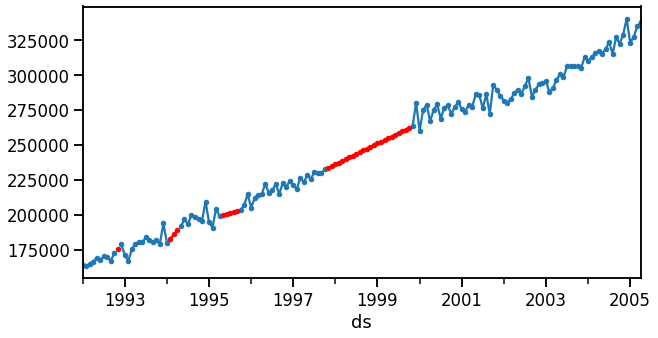

In [18]:
ax = df_deseasonalised.plot(linestyle='-', marker='.', figsize=[10, 5])
df_deseasonalised_imputed.to_frame().rename(columns={0:'y'})[df.isnull()].plot(ax=ax, legend=None, marker='.', color='r')

Note: Simpler seasonal decompositions methods exist in Statsmodels such as `seasonal_decompose`. However, the simplicity of this method has drawbacks which may or may not be relevant for your use case (e.g., naive seasonal decomposition methods may not capture seasonality which changes over time, may not return values at the start and end of a time series etc.). STL is a more advanced method that is commonly used for data imputation.

## [Optional] 4.2: Extract seasonality from Facebook Prophet


We will discuss Facebook Prophet later in the course. However, we will demonstrate here how it can also be used to extract the seasonal component of a time series.

In [20]:
from fbprophet import Prophet

In [21]:
# Prophet requires a dataframe with columns named `ds` and `y`
df_ = df.reset_index()
df_.head()

,ds,y
0,1992-01-01,146376.0
1,1992-02-01,147079.0
2,1992-03-01,159336.0
3,1992-04-01,163669.0
4,1992-05-01,170068.0


In [22]:
model = Prophet(daily_seasonality=False, weekly_seasonality=False, yearly_seasonality=True).fit(df_)
res = model.predict(df_)
res.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,1992-01-01,163037.459740,129901.784289,141725.533227,163037.459740,163037.459740,-26775.256883,-26775.256883,-26775.256883,-26775.256883,-26775.256883,-26775.256883,0.0,0.0,0.0,136262.202857
1,1992-02-01,164079.262116,133266.634263,145037.939992,164079.262116,164079.262116,-24831.007799,-24831.007799,-24831.007799,-24831.007799,-24831.007799,-24831.007799,0.0,0.0,0.0,139248.254316
2,1992-03-01,165053.851434,160778.002600,172084.667236,165053.851434,165053.851434,1385.986521,1385.986521,1385.986521,1385.986521,1385.986521,1385.986521,0.0,0.0,0.0,166439.837955
3,1992-04-01,166095.653809,157209.535254,168887.287153,166095.653809,166095.653809,-2915.754962,-2915.754962,-2915.754962,-2915.754962,-2915.754962,-2915.754962,0.0,0.0,0.0,163179.898848
4,1992-05-01,167103.849656,169914.870417,181007.618051,167103.849656,167103.849656,8429.443240,8429.443240,8429.443240,8429.443240,8429.443240,8429.443240,0.0,0.0,0.0,175533.292897


We can extract the seasonal component from the `yearly` column.

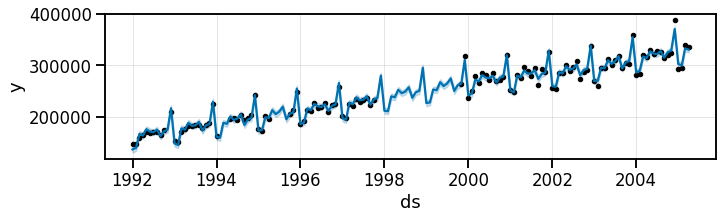

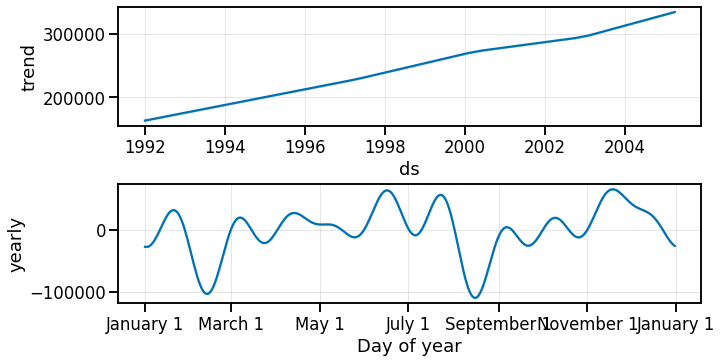

In [23]:
model.plot(res, figsize=[10, 3])
model.plot_components(res, figsize=[10, 5]);

In [24]:
# Extract seasonal component
seasonal_component = res.set_index('ds')['yearly']
seasonal_component.head()

ds
1992-01-01   -26775.256883
1992-02-01   -24831.007799
1992-03-01     1385.986521
1992-04-01    -2915.754962
1992-05-01     8429.443240
Name: yearly, dtype: float64

<AxesSubplot:xlabel='ds'>

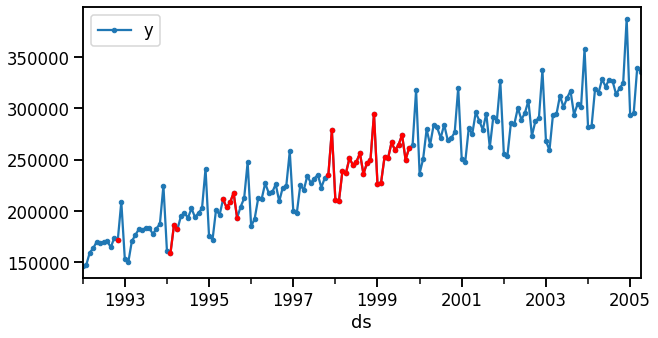

In [25]:
# De-seasonlise original data
df_deseasonalised = df['y'] - seasonal_component

# Perform linear interpolation on de-seasonalised data
df_deseasonalised_imputed = df_deseasonalised.interpolate(method='linear')

# Add seasonal component back to get the final imputed time series
df_imputed = df_deseasonalised_imputed + seasonal_component

# Plot the imputed time series
df_imputed = df_imputed.to_frame().rename(columns={0:'y'})
ax = df_imputed.plot(linestyle='-', marker='.', figsize=[10, 5])
df_imputed[df.isnull()].plot(ax=ax, legend=None, marker='.', color='r')

# Summary

If your dataset is not strongly seasonal then simple methods such as forward fill or linear interpolation would normally be sufficient. If your data is strongly seasonal and especially if there are large gaps then performing a seasonal decomposition and interpolating the de-seasonalised data is recommended.
